# Proof of Concept: Automatic root Cause Analysis for LTE Networks based on unsupervised Techniques

This Jupyter Notebook is a demo related to the paper "Automatic root cause analysis for LTE networks based on unsupervised techniques." IEEE Transactions on Vehicular Technology (2016), 2369-2386, written by Gómez-Andrades, Ana, et al. 

The increase in the size and complexity of current cellular networks is complicating their operation and maintenance tasks. While the end-to-end user experience in terms of throughput and latency has been significantly improved, cellular  networks have also become more prone to failures. In this context, mobile operators start to concentrate their efforts on creating self-healing networks, i.e., those networks capable of troubleshooting in an automatic way, making the network  more reliable and reducing costs. In the paper "Automatic root cause analysis for LTE networks based on unsupervised techniques.", an automatic diagnosis system based on unsupervised techniques for Long-Term Evolution (LTE) networks is proposed. In particular, this system is built through an iterative process, using self-organizing maps (SOMs) and Ward’s hierarchical clustering method, to guarantee the quality of the solution. Furthermore, to obtain a number of relevant clusters and label them properly from a technical point of view, an approach based on the analysis of the statistical behavior of each cluster is proposed.

Diagnosis  is  one  of  the  most  critical  functions  in  a  self-healing  network.  It  is,  therefore,  essential  to  ensure  that  the automatic fault identification  is  accurate and  reliable, so  that experts do not have to check every diagnosis provided by the system.  Consequently,  the  automatic  diagnosis  system  must emulate the manual process followed by an expert to determine the existing faults. Through this manual procedure, experts analyze the symptoms or measurements that may reveal the cause of the problem. These  symptoms  could  be  alarms,  key  performance  indicators (KPIs), configuration parameters, etc. Thus, depending on which symptoms are degraded and their level of deterioration, experts can differentiate the fault of a cell. However, this raises difficulties that experts must face, i.e., difficulties that are also present when the diagnosis system is designed. First, the system must be able to operate with a wide range of symptoms. Furthermore, each symptom has different features, e.g., it can be either discrete or continuous, its range of variation can be limited or not, etc. Finally, the automatic diagnosis system, similar to experts, must “know” the effects that each fault causes on the symptoms to perform identification from a plurality of faults. In addition, automating the diagnosis process implies that the diagnosis system has to learn how the faults behave. A possible approach could be to extract the information from stored cases that have been solved satisfactorily and whose fault is known (i.e., labeled cases). This data set will allow obtaining an automatic system through supervised learning. Nevertheless, since experts do not tend to collect the values of the KPI along with a standard label associated to the cases that they resolve, the available historical records are characterized by being scarce. In particular, they do not have a high variety of faults, and for each specific fault, there is not a high number of labeled cases. As a result, the historical data obtained from a real network is not sufficiently rich to build a diagnosis system with supervised techniques. Although this valuable information could be obtained from expert knowledge, this would give rise to a system that would highly depend on the notions provided by the experts and how this knowledge is translated into the system.
Furthermore, each network may have different faults, and not all of them may be known by the experts. Consequently, the unsupervised technique proposed in the paper is the best solution for the design of the automatic diagnosis system, since it avoids the use of labeled cases for its construction.
Unsupervised methods allow building systems from a dataset taken directly from the real network, without including any information about the fault cause in question. Moreover, the  dataset used to design the system contains symptoms from both healthy and faulty cells because these two states cannot be distinguished, i.e., the data set is unlabeled. Therefore, one additional aspect to consider, arising from the use of unsupervised techniques, is that the obtained system must be able to identify not only  the cause of the problems but whether a cell has a problem or not as well. As a result, the automatic system simultaneously performs the diagnosis and the detection functions of the self-healing procedure. Although the data set is previously filtered by the detection phase, there will be some samples of healthy cells (due to nonidealities of the detection phase) that arrive to the diagnosis phase. This leads to a diagnosis system that is trained with both healthy and problematic cases. Thus, those healthy cases should also be identified.

The original paper evaluates on synthetic and real LTE data. Since we have only access to the simulated dataset, we demonstrate some of the paper's concepts only on the synthetic data. <br>
For the data source and further references see: http://webpersonal.uma.es/de/rbarco/home.html

In [116]:
# Import all required Python libraries

import pandas as pd
import numpy as np
import sompy
import scipy
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
import plotly
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
from tqdm import tqdm

# Semi-automatic Design Step

Before the proposed diagnosis system can be used, it must be designed through an iterative process with the goal of obtaining an accurate system. The proposed design method
consists of different unsupervised techniques with the Self-organizing Map (SOM) as the key algorithm, along with the validation of the experts who determine if the obtained diagnosis system makes sense. Thus, this semiautomatic design is carried out through three different phases:
<ol>
    <li>unsupervised SOM training,
    <li>unsupervised clustering,
    <li>labeling by experts.
<ol>

The synthetic dataset consists of two different collections: the training set, which will be used to design the proposed diagnosis system, and thus, it  is  used  without  labels;  and  the  validation  set,  which  will be used to evaluate the system. In particular, the data set has been generated by a dynamic LTE system-level simulator implemented in MATLAB, whose 57 macrocells are evenly distributed across the entire scenario, forming a hexagonal grid.

To carry out the root cause analysis of this scenario, the chosen indicators are statistics at the cell level related both to radio environment quality and the efficiency of the offered service. In particular, the used KPIs are the following:
<ul>
    <li>Retainability, which is the ratio of connections that have finished successfully to the total numbern of finished connections;
    <li>HOSR, which is calculated as the ratio of the number of successful handovers to the total;
    <li>the 95th percentile of the reference signal received power (RSRP) measured  by  all  the  users  connected  to  the cell. The RSRP is defined as the average power received from the serving cell over the resource elements that carry the cell-specific reference signals (RS) within the considered measurement frequency bandwidth;
    <li>the fifth percentile of the reference signal received quality (RSRQ), which is the ratio of the RSRP multiplied by the total number of resource blocks to the total received power within the measurement bandwidth;
    <li>the  95th  percentile  of the signal-to-interference-plus-noise ratio (SINR). In particular, the SINR of the users is the ratio of the desired power received to the total power of noise and interference;
    <li>the average throughput of all users in a cell (AvThroughput), where the user throughput is calculated on the basis of their SINR;
    <li>the  95th  percentile  of  the  distance  between  the  base station and each user (Distance);

Therefore, the input vector of the system consists of the previous KPIs; formally, it can be expressed as <br>
S=[Retainability, HOSR, RSRP, RSRQ, SINR, AvThroughput, Distance]


In [117]:
# Read in all labeled training data and name columns
trainingdata = pd.read_csv("training.txt", sep=r"\s+",skiprows=[0],header=None)

In [118]:
trainingdata.columns = ["Retainability", "HOSR", "RSRP", "RSRQ", "SINR", "Throughput", "Distance", "FaultCause"]

In [119]:
# Remove the label 'Fault Cause' from training data and use it later for evaluation
y = trainingdata['FaultCause'].copy().astype(int)

In [120]:
trainingdata = trainingdata.drop('FaultCause',axis=1)

In [121]:
trainingdata.head(n=5)

,Retainability,HOSR,RSRP,RSRQ,SINR,Throughput,Distance
0,0.853,0.609,-66.728,-20.042,10.836,148.692,0.713
1,0.909,0.800,-61.816,-19.071,15.236,205.652,0.601
2,0.963,0.818,-61.778,-18.862,16.395,251.339,0.587
3,0.940,0.889,-63.843,-19.436,14.816,232.213,0.586
4,0.952,0.900,-61.796,-19.403,14.402,191.574,0.629


In [122]:
KPIs = trainingdata.copy()

## 1. Normalize Data

The input of the diagnosis system must be preprocessed to suit the technical requirements of the system. In particular, for the proposed system, the input data must be quantitative, i.e., they can be expressed in terms of numbers (e.g.,  power  and throughput). In particular, performance indicators of mobile networks are characterized by being numerical variables. As a consequence, this system is appropriate for automating the troubleshooting process in a mobile network by working directly
with KPIs, avoiding both the discretization of the variables and the definition of the thresholds by experts.
However, given that the proposed system is based on the Euclidean distance, the raw data taken from the network must be normalized. This ensures that their dynamic ranges are similar, and thus, there are no high values that dominate the training

In [123]:
normalized = trainingdata.copy()

In [124]:
rangescaler = preprocessing.MinMaxScaler()
rangescaler.fit(normalized)
scaled1 = rangescaler.transform(normalized)
scaled1df = pd.DataFrame(scaled1)
scaled1df.columns = ["Retainability", "HOSR", "RSRP", "RSRQ", "SINR", "Throughput", "Distance"]

In [125]:
# Take a look at the first range normalized events
scaled1df.head(n=5)

,Retainability,HOSR,RSRP,RSRQ,SINR,Throughput,Distance
0,0.020000,0.370370,0.729582,0.128493,0.476661,0.479031,0.177320
1,0.393333,0.677939,0.997924,0.440411,0.844738,0.768123,0.061856
2,0.753333,0.706924,1.000000,0.507549,0.941693,1.000000,0.047423
3,0.600000,0.821256,0.887189,0.323161,0.809603,0.902929,0.046392
4,0.680000,0.838969,0.999017,0.333762,0.774971,0.696672,0.090722


In [126]:
standardscaler = preprocessing.StandardScaler()
standardscaler.fit(scaled1df)
scaled2 = standardscaler.transform(scaled1df)
scaled2df = pd.DataFrame(scaled2)
scaled2df.columns = ["Retainability", "HOSR", "RSRP", "RSRQ", "SINR", "Throughput", "Distance"]

In [127]:
# Take a look at the first range and Z-score normalized events
scaled2df.head(n=5)

,Retainability,HOSR,RSRP,RSRQ,SINR,Throughput,Distance
0,-5.369578,-4.270541,1.833438,-3.618251,-1.747126,1.240194,-1.565099
1,-3.098333,-1.918184,3.475686,-1.602502,0.545702,3.649734,-2.535459
2,-0.908203,-1.696496,3.488391,-1.168628,1.149653,5.582399,-2.656754
3,-1.841036,-0.822060,2.797991,-2.360224,0.326841,4.773325,-2.665418
4,-1.354341,-0.686584,3.482373,-2.291718,0.111106,3.054202,-2.292869


In [128]:
X = scaled2df.copy()

## 2. Train Self-organizing Map

A Self-organizing Map (SOM) is a type of unsupervised neural network capable of acquiring knowledge and learning from a set of unlabeled data. Therefore, in this paper,
SOM is used as the centerpiece to classify the  cell’s state according to the behavior of its symptoms, subsequently identifying the fault cause. The great advantage of SOM  is its capacity for processing high-dimensional data and reducing it to a lower dimension (e.g., two), which enormously facilitates the interpretation and understanding of  the final diagnosis. Furthermore, this system does not require discrete data. This enables working directly with raw data, with no discretization methods that cause loss of information.

In [129]:
# Rectangular Grid
mapsize = [10,10]

In [130]:
Xarray=np.array(X)

In [39]:
som = sompy.SOMFactory.build(Xarray, mapsize, mask=None, mapshape='planar', lattice='rect', normalization='var', initialization='pca', neighborhood='bubble', 
                             training='batch', name='sompy')

In [ ]:
som.train(train_rough_len=1000,train_rough_radiusin=10,train_rough_radiusfin=2,train_finetune_len=1000,train_finetune_radiusin=1,train_finetune_radiusfin=0,n_job=1) 

## 3. Visualization of 2-dimensional Embedding

Each heatmap represents the intensity of a single feature or data column as learned by the SOM grid.
Note the heatmap is discretized and each ‘block’ in each subfigure is a unique neuron, the neurons have the same position across all subfigures, 
i.e. the block on the very top left of the latitude subfigure is the same neuron in the longitude subfigure and the monthly median temperature subgfigure and so on. 
In general similar heatmaps in different component planes represent correlation of features,  dissimilarity represents negligible correlation and inversion represents anti-correlation. 

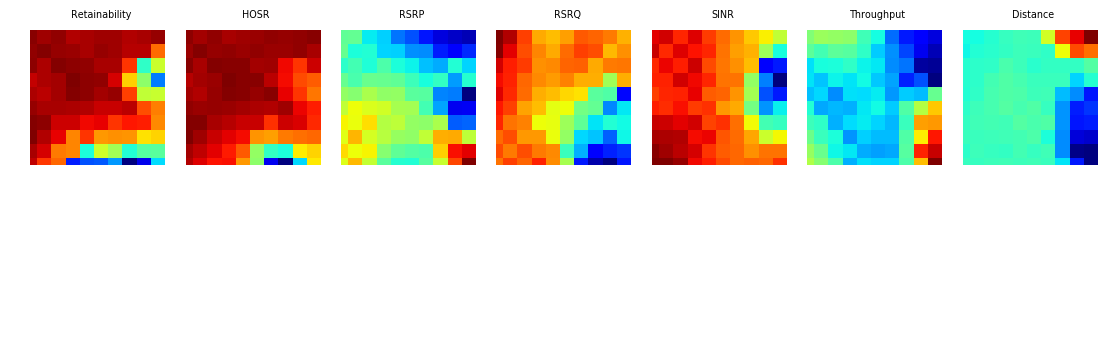

In [41]:
som.component_names = ["Retainability", "HOSR", "RSRP", "RSRQ", "SINR", "Throughput", "Distance"]
v = sompy.mapview.View2DPacked(50, 50, ' ',text_size=8)  
v.show(som, what='codebook', which_dim='all', cmap='jet', col_sz=7) 

The U-matrix is also a heatmap but can be interpreted like a topographic map (a map that shows the elevation contours across a region) across our SOM grid. 
The ‘hills’ (red) in the U-matrix represent large distances between neighbors and vice versa for valleys (blue).

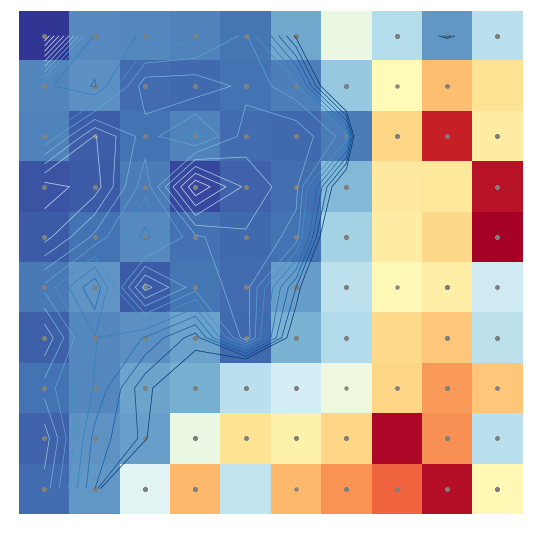

In [42]:
u = sompy.umatrix.UMatrixView(50, 50, 'umatrix', show_axis=True, text_size=8, show_text=True)

#This is the Umat value
UMAT  = u.build_u_matrix(som, distance=1, row_normalized=False)

#Here you have Umatrix plus its render
UMAT = u.show(som, distance2=1, row_normalized=False, show_data=True, contooor=True, blob=False)

## 4. Ward's Hierachical Clustering

Then, SOM is clustered into different number of groups using Ward’s hierarchical clustering algorithm. To that end, the Euclidean distance between each pair of classes is calculated. Then, the Ward algorithm iteratively merges the closest two classes into a new class based on the minimum distance.


In [44]:
def WardClus(Embedding, n_cluster):
    ward = AgglomerativeClustering(n_clusters=n_cluster, linkage='ward',affinity='euclidean').fit(Embedding)
    label = ward.labels_
    
    return label

In [45]:
embedding = som.codebook.matrix # Take neurons as data that should be clustered

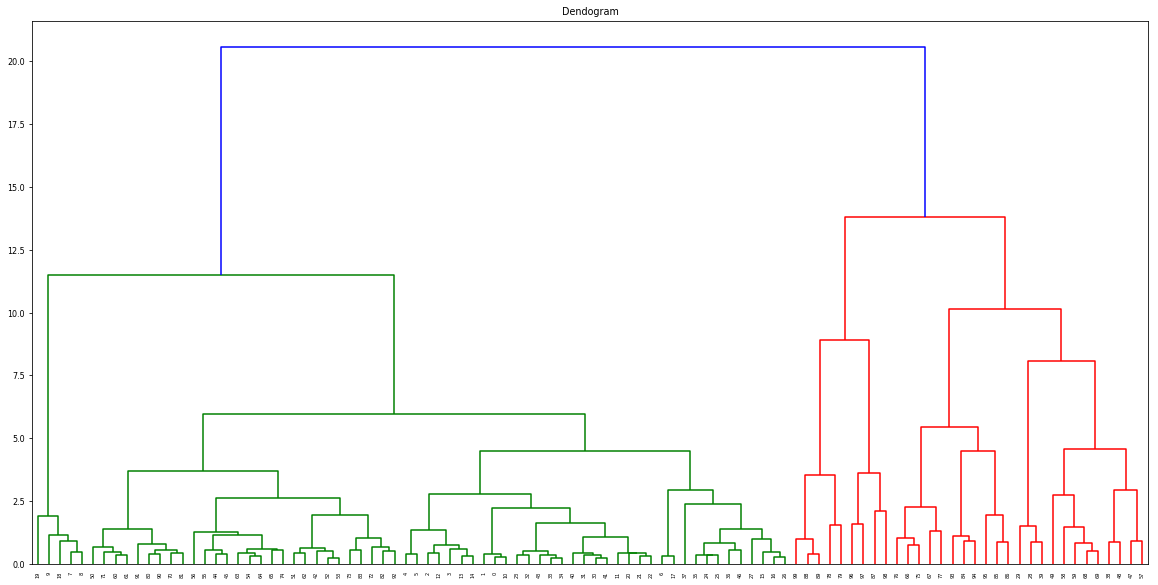

In [46]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(20, 10))  
plt.title("Dendogram")  
dend = shc.dendrogram(shc.linkage(embedding, method='ward')) 

## 5. Davies-Bouldin Index 

Each classification is evaluated through the Davies-Bouldin Index (DB), which determines how well is each clustering, and the clustering with the minimum index (i.e., the best clustering according to the DB metric) is selected. The DB identifies clusters which are far from each other and compact.

In [47]:
from scipy.spatial.distance import euclidean, cdist

def db_index(X, y):
    """
    Davies-Bouldin index is an internal evaluation method for
    clustering algorithms. Lower values indicate tighter clusters that are
    better separated. Reference:
    https://en.wikipedia.org/wiki/Davies%E2%80%93Bouldin_index

    Arguments
    ----------
    X : 2D array (n_samples, embed_dim)
        Vector for each example.
    y : 1D array (n_samples,) or 2D binary array (n_samples, n_classes)
        True labels for each example.

    Returns
    ----------
    dbi : float
        Calculated Davies-Bouldin index.
    """
    # get unique labels
    if y.ndim == 2:
        y = np.argmax(axis=1)
    uniqlbls = np.unique(y)
    n = len(uniqlbls)
    # pre-calculate centroid and sigma
    centroid_arr = np.empty((n, X.shape[1]))
    sigma_arr = np.empty(n)
    for i,k in enumerate(uniqlbls):
        Xk = X[np.where(y==k)[0],...]
        Ak = np.mean(Xk, axis=0)
        centroid_arr[i,...] = Ak
        sigma_arr[i,...] = np.mean(cdist(Xk, Ak.reshape(1,-1)))
    # loop over non-duplicate cluster pairs
    dbi = 0
    for i in range(n):
        max_Rij = 0
        for j in range(n):
            if j != i:
                Rij = np.divide(sigma_arr[i] + sigma_arr[j], 
                                euclidean(centroid_arr[i,...], centroid_arr[j,...]))
                if Rij > max_Rij:
                    max_Rij = Rij
        dbi += max_Rij
    return dbi/n

In [48]:
indexls = []

for i in range(2,10):
    labelvec = WardClus(embedding,i)
    DBindex = db_index(embedding,labelvec)
    indexls.append(DBindex)

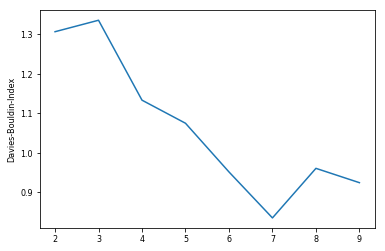

Minimal DB-Index: 0.8348493792715264 for 7 Cluster.


In [49]:
plt.plot(range(2,10),indexls)
plt.ylabel('Davies-Bouldin-Index')
plt.show()
print("Minimal DB-Index:",min(indexls),"for",indexls.index(min(indexls))+2, "Cluster.")

Here the DB is minimal for 7 Clusters, thus we take 7 as the optimal amount of clusters.

In [51]:
# Note that n_clusters is now set to 7!
ward = AgglomerativeClustering(n_clusters=7, linkage='ward', affinity='euclidean').fit(embedding)
label = ward.labels_

# Cluster-Symptom-Relation based on Statistical Cluster Behaviour

## 1. Ward's Clustering

By now, Ward's Clustering grouped close neurons together. Since every data point can be mapped to its closest neuron (BMU) we can derive a clustering of our original KPI dataset.

In [52]:
bmumap = som.find_bmu(Xarray)

In [53]:
bmucluster = pd.DataFrame({'neuron': range(0, 100),'cluster': label})

In [54]:
datalabel=[]

for x in bmumap[0]:
    bmu = int(x) #get bmu neuron 
    row = bmucluster[bmucluster['neuron']==bmu].cluster.item()
    datalabel.append(row)

In [55]:
KPIcluster = KPIs.copy()

In [56]:
KPIcluster['cluster'] = datalabel

In [58]:
# Here we have added the cluster assignment as the very right column 'cluster'
KPIcluster.head(n=5)

,Retainability,HOSR,RSRP,RSRQ,SINR,Throughput,Distance,cluster
0,0.853,0.609,-66.728,-20.042,10.836,148.692,0.713,2
1,0.909,0.800,-61.816,-19.071,15.236,205.652,0.601,5
2,0.963,0.818,-61.778,-18.862,16.395,251.339,0.587,5
3,0.940,0.889,-63.843,-19.436,14.816,232.213,0.586,5
4,0.952,0.900,-61.796,-19.403,14.402,191.574,0.629,5


In [131]:
KPIcluster['FaultCause'] = y

In [132]:
wardcluster = bmucluster['cluster'].values
msz = som.codebook.mapsize

In [133]:
plotly.tools.set_credentials_file(username='tandeu', api_key='klaNLt1mzs5mLuD2LbEa')
fig = ff.create_annotated_heatmap(wardcluster.reshape(msz[0], msz[1])[::],
                                 text=wardcluster.reshape(msz[0], msz[1])[::],
                                 hoverinfo='text',colorscale='Jet')
py.iplot(fig, filename='ClusterHeatmap')

This plot shows the clustering of the SOM neurons.

## 2. Labeling by Experts

Afterwards each cluster is studied to examine the statistical behavior of the cluster's KPI values. As a result, the cluster-symptom relation can be determined. This statistical information also helps verify whether the clustering is correct or not. That is, it allows experts to detect if a cluster is associated with more than one cause. Finally, taking into account the cluster-symptom relations, the experts should identify the cause associated with each cluster based on their knowledge and, as a consequence, provide a suitable label to each cluster. As previously stated, one of the clusters will correspond to the normal behavior of the cells, on the other hand, the remaining cases will have a descriptive label related with the possible fault cause

In [142]:
# First, for each cluster we take a look at the corresponding boxplots (probability functions) over all KPI values to identify possible root causes.
cluster0 = KPIcluster[KPIcluster['cluster']==0]
cluster1 = KPIcluster[KPIcluster['cluster']==1]
cluster2 = KPIcluster[KPIcluster['cluster']==2]
cluster3 = KPIcluster[KPIcluster['cluster']==3]
cluster4 = KPIcluster[KPIcluster['cluster']==4]
cluster5 = KPIcluster[KPIcluster['cluster']==5]
cluster6 = KPIcluster[KPIcluster['cluster']==6]

In [143]:
y0 = cluster0['Retainability']
y1 = cluster0['HOSR']
y2 = cluster0['RSRP']
y3 = cluster0['RSRQ']
y4 = cluster0['SINR']
y5 = cluster0['Throughput']
y6 = cluster0['Distance']

trace0 = go.Box(
    y=y0,
    name = 'Retainability'
)
trace1 = go.Box(
    y=y1,
    name = 'HOSR'
)
trace2 = go.Box(
    y=y2,
    name = 'RSRP'
)
trace3 = go.Box(
    y=y3,
    name = 'RSRQ'
)
trace4 = go.Box(
    y=y4,
    name= 'SINR'
)
trace5 = go.Box(
    y=y5,
    name = 'Throughput'
)
trace6 = go.Box(
    y=y6,
    name = 'Distance'
)


dataCluster0 = [trace0, trace1, trace2, trace3, trace4, trace5, trace6]

layout = go.Layout(
    title = "Cluster 0"
)

fig = go.Figure(data=dataCluster0,layout=layout)
py.iplot(fig, filename = "Cluster0")

In [144]:
y0 = cluster1['Retainability']
y1 = cluster1['HOSR']
y2 = cluster1['RSRP']
y3 = cluster1['RSRQ']
y4 = cluster1['SINR']
y5 = cluster1['Throughput']
y6 = cluster1['Distance']

trace0 = go.Box(
    y=y0,
    name = 'Retainability'
)
trace1 = go.Box(
    y=y1,
    name = 'HOSR'
)
trace2 = go.Box(
    y=y2,
    name = 'RSRP'
)
trace3 = go.Box(
    y=y3,
    name = 'RSRQ'
)
trace4 = go.Box(
    y=y4,
    name= 'SINR'
)
trace5 = go.Box(
    y=y5,
    name = 'Throughput'
)
trace6 = go.Box(
    y=y6,
    name = 'Distance'
)


dataCluster1 = [trace0, trace1, trace2, trace3, trace4, trace5, trace6]

layout = go.Layout(
    title = "Cluster 1"
)

fig = go.Figure(data=dataCluster1,layout=layout)
py.iplot(fig, filename = "Cluster1")

In [145]:
y0 = cluster2['Retainability']
y1 = cluster2['HOSR']
y2 = cluster2['RSRP']
y3 = cluster2['RSRQ']
y4 = cluster2['SINR']
y5 = cluster2['Throughput']
y6 = cluster2['Distance']

trace0 = go.Box(
    y=y0,
    name = 'Retainability'
)
trace1 = go.Box(
    y=y1,
    name = 'HOSR'
)
trace2 = go.Box(
    y=y2,
    name = 'RSRP'
)
trace3 = go.Box(
    y=y3,
    name = 'RSRQ'
)
trace4 = go.Box(
    y=y4,
    name= 'SINR'
)
trace5 = go.Box(
    y=y5,
    name = 'Throughput'
)
trace6 = go.Box(
    y=y6,
    name = 'Distance'
)


dataCluster2 = [trace0, trace1, trace2, trace3, trace4, trace5, trace6]

layout = go.Layout(
    title = "Cluster 2"
)

fig = go.Figure(data=dataCluster2,layout=layout)
py.iplot(fig, filename = "Cluster2")

In [146]:
y0 = cluster3['Retainability']
y1 = cluster3['HOSR']
y2 = cluster3['RSRP']
y3 = cluster3['RSRQ']
y4 = cluster3['SINR']
y5 = cluster3['Throughput']
y6 = cluster3['Distance']

trace0 = go.Box(
    y=y0,
    name = 'Retainability'
)
trace1 = go.Box(
    y=y1,
    name = 'HOSR'
)
trace2 = go.Box(
    y=y2,
    name = 'RSRP'
)
trace3 = go.Box(
    y=y3,
    name = 'RSRQ'
)
trace4 = go.Box(
    y=y4,
    name= 'SINR'
)
trace5 = go.Box(
    y=y5,
    name = 'Throughput'
)
trace6 = go.Box(
    y=y6,
    name = 'Distance'
)


dataCluster3 = [trace0, trace1, trace2, trace3, trace4, trace5, trace6]

layout = go.Layout(
    title = "Cluster 3"
)

fig = go.Figure(data=dataCluster3,layout=layout)
py.iplot(fig, filename = "Cluster3")

In [147]:
y0 = cluster4['Retainability']
y1 = cluster4['HOSR']
y2 = cluster4['RSRP']
y3 = cluster4['RSRQ']
y4 = cluster4['SINR']
y5 = cluster4['Throughput']
y6 = cluster4['Distance']

trace0 = go.Box(
    y=y0,
    name = 'Retainability'
)
trace1 = go.Box(
    y=y1,
    name = 'HOSR'
)
trace2 = go.Box(
    y=y2,
    name = 'RSRP'
)
trace3 = go.Box(
    y=y3,
    name = 'RSRQ'
)
trace4 = go.Box(
    y=y4,
    name= 'SINR'
)
trace5 = go.Box(
    y=y5,
    name = 'Throughput'
)
trace6 = go.Box(
    y=y6,
    name = 'Distance'
)


dataCluster4 = [trace0, trace1, trace2, trace3, trace4, trace5, trace6]

layout = go.Layout(
    title = "Cluster 4"
)

fig = go.Figure(data=dataCluster4,layout=layout)
py.iplot(fig, filename = "Cluster4")

In [148]:
y0 = cluster5['Retainability']
y1 = cluster5['HOSR']
y2 = cluster5['RSRP']
y3 = cluster5['RSRQ']
y4 = cluster5['SINR']
y5 = cluster5['Throughput']
y6 = cluster5['Distance']

trace0 = go.Box(
    y=y0,
    name = 'Retainability'
)
trace1 = go.Box(
    y=y1,
    name = 'HOSR'
)
trace2 = go.Box(
    y=y2,
    name = 'RSRP'
)
trace3 = go.Box(
    y=y3,
    name = 'RSRQ'
)
trace4 = go.Box(
    y=y4,
    name= 'SINR'
)
trace5 = go.Box(
    y=y5,
    name = 'Throughput'
)
trace6 = go.Box(
    y=y6,
    name = 'Distance'
)


dataCluster5 = [trace0, trace1, trace2, trace3, trace4, trace5, trace6]

layout = go.Layout(
    title = "Cluster 5"
)

fig = go.Figure(data=dataCluster5,layout=layout)
py.iplot(fig, filename = "Cluster5")

In [149]:
y0 = cluster6['Retainability']
y1 = cluster6['HOSR']
y2 = cluster6['RSRP']
y3 = cluster6['RSRQ']
y4 = cluster6['SINR']
y5 = cluster6['Throughput']
y6 = cluster6['Distance']

trace0 = go.Box(
    y=y0,
    name = 'Retainability'
)
trace1 = go.Box(
    y=y1,
    name = 'HOSR'
)
trace2 = go.Box(
    y=y2,
    name = 'RSRP'
)
trace3 = go.Box(
    y=y3,
    name = 'RSRQ'
)
trace4 = go.Box(
    y=y4,
    name= 'SINR'
)
trace5 = go.Box(
    y=y5,
    name = 'Throughput'
)
trace6 = go.Box(
    y=y6,
    name = 'Distance'
)


dataCluster6 = [trace0, trace1, trace2, trace3, trace4, trace5, trace6]

layout = go.Layout(
    title = "Cluster 6"
)

fig = go.Figure(data=dataCluster6,layout=layout)
py.iplot(fig, filename = "Cluster6")

In [150]:
# Then experts assign fraud labels to the clusters
Faultlabels = ['Antenna Downtilt','Coverage Hole','Inter-system Inference','Too late Handover','Overshoot Coverage', 'Weak Coverage', 'Normal']

In [151]:
rootcausels = []
for i in range(7):
    clusterdf = KPIcluster[KPIcluster['cluster']==i]
    cause = clusterdf['FaultCause']
    mode = int(cause.mode()[0])
    rootcausemap = Faultlabels[mode-1]
    print("Cluster", i, "has Root Cause:",rootcausemap)
    rootcausels.append(rootcausemap)

Cluster 0 has Root Cause: Normal
Cluster 1 has Root Cause: Too late Handover
Cluster 2 has Root Cause: Too late Handover
Cluster 3 has Root Cause: Overshoot Coverage
Cluster 4 has Root Cause: Weak Coverage
Cluster 5 has Root Cause: Antenna Downtilt
Cluster 6 has Root Cause: Inter-system Inference


In [152]:
wardcluster = bmucluster['cluster'].values

In [153]:
rootcauseneurons = []

for i in range(0,len(wardcluster)):
    if wardcluster[i] == 0:
        rootcauseneurons.append(rootcausels[0])
    elif wardcluster[i] == 1:
        rootcauseneurons.append(rootcausels[1])
    elif wardcluster[i] == 2:
        rootcauseneurons.append(rootcausels[2])
    elif wardcluster[i] == 3:
        rootcauseneurons.append(rootcausels[3])
    elif wardcluster[i] == 4:
        rootcauseneurons.append(rootcausels[4])
    elif wardcluster[i] == 5:
        rootcauseneurons.append(rootcausels[5])
    elif wardcluster[i] == 6:
        rootcauseneurons.append(rootcausels[6])

In [154]:
fig = ff.create_annotated_heatmap(wardcluster.reshape(msz[0], msz[1])[::],
                                 text=np.array(rootcauseneurons).reshape(msz[0], msz[1])[::],
                                 hoverinfo='text',colorscale='Jet')
py.iplot(fig, filename='RootCauseHeatmap')

Now, each cluster is assigned to a root cause which can be noticed by hovering.

# Exploitation Stage

Once the system has been designed, it can be used to automatically perform the diagnosis in the exploitation phase. This diagnosis process can be periodically performed to determine whether the identified fault is sporadic, continuous, or periodic and to track the evolution of the fault over time when either compensation or recovery tasks are carried out.

In [155]:
# Read in labeled valdidation data
validationdata = pd.read_csv("validation.txt", sep=r"\s+",skiprows=[0],header=None)

In [156]:
validationdata.columns = ["Retainability", "HOSR", "RSRP", "RSRQ", "SINR", "Throughput", "Distance", "FaultCause"]

In [157]:
# Here we see the first events labeled with a frault cause 
validationdata.head(n=5)

,Retainability,HOSR,RSRP,RSRQ,SINR,Throughput,Distance,FaultCause
0,0.907,0.850,-64.372,-19.685,14.329,197.534,0.712,1.0
1,0.918,0.733,-62.968,-18.673,15.053,207.534,0.545,1.0
2,0.868,0.563,-68.681,-20.572,12.101,220.341,0.662,1.0
3,0.931,0.789,-61.692,-19.094,13.010,167.657,0.550,1.0
4,1.000,1.000,-63.932,-19.359,15.203,225.098,0.543,1.0


In [158]:
test = validationdata.drop('FaultCause',axis=1)

In [159]:
ytest = validationdata['FaultCause']

In [160]:
normalizedtest = test.copy()

In [161]:
# The validation data are normalized as well
testrangescaler = preprocessing.MinMaxScaler()
testrangescaler.fit(normalizedtest)
scaledtest1 = testrangescaler.transform(normalizedtest)
scaledtest1df = pd.DataFrame(scaledtest1)
scaledtest1df.columns = ["Retainability", "HOSR", "RSRP", "RSRQ", "SINR", "Throughput", "Distance"]

In [162]:
teststandscaler = preprocessing.StandardScaler()
teststandscaler.fit(scaledtest1df)
scaledstandtest1 = teststandscaler.transform(scaledtest1df)
scaledtest2df = pd.DataFrame(scaledstandtest1)
scaledtest2df.columns = ["Retainability", "HOSR", "RSRP", "RSRQ", "SINR", "Throughput", "Distance"]

In [163]:
scaledtest2df.head(n=5)

,Retainability,HOSR,RSRP,RSRQ,SINR,Throughput,Distance
0,-3.213872,-1.073487,2.677251,-2.719128,0.116863,3.772851,-1.564535
1,-2.749950,-2.373843,3.158034,-0.693985,0.498085,4.226181,-3.013237
2,-4.858685,-4.263248,1.201685,-4.494130,-1.056290,4.806760,-1.998278
3,-2.201679,-1.751450,3.594985,-1.536461,-0.577656,2.418439,-2.969863
4,0.708375,0.593635,2.827924,-2.066760,0.577068,5.022409,-3.030587


In [164]:
normalizedtest = scaledtest2df.copy()

In [165]:
# Based on the computed SOM clustering we assign each event from the validation data set to the best fitting cluster
from scipy.spatial import distance
testlabels = []
for state in tqdm(normalizedtest.itertuples()):
    newevent = state[1:8]
    distls = []
    for neuron in embedding:
        dst = distance.euclidean(newevent, neuron)
        distls.append(dst)
    BMUdist = min(distls)
    index = distls.index(min(distls))
    BMU = embedding[index]
    clusterlabel = bmucluster.iloc[index,0]
    testlabels.append(clusterlabel)

4009it [00:06, 632.44it/s]


In [166]:
normalizedtest['FaultCause'] = ytest

In [167]:
normalizedtest['Class'] = testlabels

In [168]:
normalizedtest.head(n=5)

,Retainability,HOSR,RSRP,RSRQ,SINR,Throughput,Distance,FaultCause,Class
0,-3.213872,-1.073487,2.677251,-2.719128,0.116863,3.772851,-1.564535,1.0,5
1,-2.749950,-2.373843,3.158034,-0.693985,0.498085,4.226181,-3.013237,1.0,5
2,-4.858685,-4.263248,1.201685,-4.494130,-1.056290,4.806760,-1.998278,1.0,2
3,-2.201679,-1.751450,3.594985,-1.536461,-0.577656,2.418439,-2.969863,1.0,5
4,0.708375,0.593635,2.827924,-2.066760,0.577068,5.022409,-3.030587,1.0,5


Based on the computed SOM clustering we obtain a cluster assignment for all new data from the valdidation dataset.

## Evaluation

In the evaluation we check if the cluster assignment fits the given labels.

In [169]:
FaultCauseCatls = []
for event in normalizedtest['FaultCause']:
    if int(event) == 1:
        FaultCauseCatls.append(Faultlabels[0])
    if int(event) == 2:
        FaultCauseCatls.append(Faultlabels[1])
    if int(event) == 3:
        FaultCauseCatls.append(Faultlabels[2])
    if int(event) == 4:
        FaultCauseCatls.append(Faultlabels[3])
    if int(event) == 5:
        FaultCauseCatls.append(Faultlabels[4])
    if int(event) == 6:
        FaultCauseCatls.append(Faultlabels[5])
    if int(event) == 7:
        FaultCauseCatls.append(Faultlabels[6])
normalizedtest['FaultCauseCat'] = FaultCauseCatls

In [170]:
ClassCatls = []
for event in normalizedtest['Class']:
    if int(event) == 0:
        ClassCatls.append(rootcausels[0])
    if int(event) == 1:
        ClassCatls.append(rootcausels[1])
    if int(event) == 2:
        ClassCatls.append(rootcausels[2])
    if int(event) == 3:
        ClassCatls.append(rootcausels[3])
    if int(event) == 4:
        ClassCatls.append(rootcausels[4])
    if int(event) == 5:
        ClassCatls.append(rootcausels[5])
    if int(event) == 6:
        ClassCatls.append(rootcausels[6])
normalizedtest['ClassCat'] = ClassCatls

In [171]:
# Here we see the validation dataset with the assigned clustering class 'Class', the corresponding root cause based on the semi-automatic Design Step (CkassCat),
# and the actual given root cause (FaultCauseCat)
normalizedtest.head(n=5)

,Retainability,HOSR,RSRP,RSRQ,SINR,Throughput,Distance,FaultCause,Class,FaultCauseCat,ClassCat
0,-3.213872,-1.073487,2.677251,-2.719128,0.116863,3.772851,-1.564535,1.0,5,Antenna Downtilt,Antenna Downtilt
1,-2.749950,-2.373843,3.158034,-0.693985,0.498085,4.226181,-3.013237,1.0,5,Antenna Downtilt,Antenna Downtilt
2,-4.858685,-4.263248,1.201685,-4.494130,-1.056290,4.806760,-1.998278,1.0,2,Antenna Downtilt,Too late Handover
3,-2.201679,-1.751450,3.594985,-1.536461,-0.577656,2.418439,-2.969863,1.0,5,Antenna Downtilt,Antenna Downtilt
4,0.708375,0.593635,2.827924,-2.066760,0.577068,5.022409,-3.030587,1.0,5,Antenna Downtilt,Antenna Downtilt


In [172]:
normals = normalizedtest['FaultCauseCat'] == "Normal" # States that are normal

In [173]:
normalclassed = normalizedtest['ClassCat'] == "Normal" # States that are classified as normal

In [174]:
fprls = []
for i in range(len(normals)):
    if normalizedtest['FaultCauseCat'][i] == 'Normal' and normalizedtest['ClassCat'][i] != 'Normal':
        fprls.append(1)
    else:
        fprls.append(0)

In [175]:
totalnormal = normalizedtest['FaultCauseCat'].tolist().count('Normal')

In [176]:
FPrate = sum(fprls)/totalnormal # Proportion of normal cases diagnosed as fault causes to the total number of normal cases

In [177]:
fnrls = []
for i in range(len(normals)):
    if normalizedtest['FaultCauseCat'][i] != 'Normal' and normalizedtest['ClassCat'][i] == 'Normal':
        fnrls.append(1)
    else:
        fnrls.append(0)

In [178]:
totalproblem = len(normalizedtest['FaultCauseCat'].tolist())-normalizedtest['FaultCauseCat'].tolist().count('Normal')

In [179]:
FNrate = sum(fnrls)/totalproblem # Proportion of problematic cases diagnosed as normal to the total number of problematic cases. 
# Incapacity of the system to detect problems in a cell, when that cell actually has a problem

In [180]:
diagnosiserrorls = []
for i in range(len(normals)):
    if normalizedtest['FaultCauseCat'][i] != 'Normal':
        if normalizedtest['FaultCauseCat'][i] == normalizedtest['ClassCat'][i]:
            diagnosiserrorls.append(0)
        else:
            diagnosiserrorls.append(1)

In [181]:
DiagnosisErrorRate = sum(diagnosiserrorls)/totalproblem

In [182]:
results = [FPrate,FNrate,DiagnosisErrorRate]

In [183]:
data = [go.Bar(
            x=['False Positive Rate', 'False Negative Rate', 'Diagnosis Error Rate'],
            y=results
    )]

py.iplot(data, filename='evaluationbar')

The false positive rate is the proportion of normal cases diagnosed as a fault cause to the total number of normal cases. Here approx. 1% of normal cases is diagnosed as fault case.

The false negative rate is the proportion of problematic cases diagnosed as normal to the total number of problematic cases. Here approx. 2.68% of fault cases is diagnosed as normal.

The diagnosis error it the proportion of problematic cases diagnosed with a fault cause different to the real one to the total number of problematic cases. Here approx. 16% of fault cases are mapped to a wrong fault cause.

# Conclusion

An automatic diagnosis system as part of a self-healing network has been demonstrated. This system is built through unsupervised techniques with the aim of obtaining a system that represents the normal and faulty behaviors of the real network. The use of unsupervised techniques guarantees that the system can be built without historical reports of solved cases while simultaneously enabling the system to identify new faults that are not previously known. Even so, the clusters derived from the proposed system are labeled by an expert based on their statistical behavior, although the effort required from experts is negligible compared with that required for supervised methods. By  performing supervised labeling, experts can detect errors in the clustering, identify the behavior of each cluster, assign the best suited fault cause to each cluster based on their knowledge, and verify whether the system is right or not. As a result, this stage is not only a labeling phase but also a validation phase. To assess the proposed approach, the diagnosis system has been evaluated on simulated LTE data. The obtained results demonstrate the value of the integrated approach. It is important to point out  that  the  proposed  diagnosis  system  is  highly  accurate, taking  into  account that it  has  been  built  using  unsupervised techniques. Finally, it can be concluded that this system could be  part of a self-healing network where specific corrective actions are taken after the automatic diagnosis stage.